# Train Your Very First Pytorch Model!


Let's learn through doing.

In this notebook we will create an image classifier to detect playing cards.

We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

Almost every pytorch model training pipeline meets this paradigm.

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
PyTorch version 2.0.0
Torchvision version 0.15.1
Numpy version 1.23.5
Pandas version 2.0.3


# Step 1. Pytorch Dataset (and Dataloader)

Would you learn how to bake a cake without first having the ingredients? No.

The same thing can be said for training a pytorch model without first having the dataset setup correctly.

This is why datasets are important:
- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [3]:
class PlayingCardDataset(Dataset):
    def __init__(self,data_dir, transform=None):
        self.data = ImageFolder(data_dir,transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [17]:
dataset = PlayingCardDataset(
    data_dir='/kaggle/input/cards-image-datasetclassification/train'
)

In [18]:
len(dataset)

7624

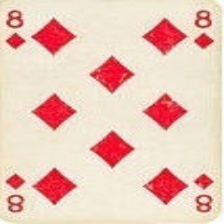

In [23]:
image,label = dataset[800]
image

In [25]:
# get dict rep of target names w folders
train_dir = '/kaggle/input/cards-image-datasetclassification/train'
target_to_class = {v:k for k, v in ImageFolder(train_dir).class_to_idx.items()} # id2label like in hf

In [31]:
transform = transforms.Compose([ # resize image and 
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

train_dir='/kaggle/input/cards-image-datasetclassification/train'
new_dataset = PlayingCardDataset(train_dir, transform)

In [36]:
# check out the new data that is transformed

image,label = new_dataset[100]
image.shape

torch.Size([3, 128, 128])

In [38]:
# iterate through the dataset!

for image, label in new_dataset: # load one example
    break
    
image
# label

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0784, 0.0824, 0.0745,  ..., 1.0000, 1.0000, 1.0000],
         [0.7490, 0.7451, 0.7412,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.0745, 0.0784, 0.0706,  ..., 1.0000, 1.0000, 1.0000],
         [0.7451, 0.7451, 0.7373,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

## Dataloader
- Batching our dataset

In [40]:
dataloader = DataLoader(new_dataset, batch_size=32, shuffle=True) # shuffle for train obv

In [50]:
for images, labels in dataloader: # load batch
    break

In [51]:
labels

tensor([22, 45,  5, 26, 52, 33, 43, 45, 41,  2, 26, 45, 46, 15, 52, 37, 28,  6,
        10, 49, 44,  3, 31,  1, 35, 17,  5,  6, 31, 10, 51, 23])

# Step 2. Pytorch Model

Pytorch datasets have a structured way of organizing your data, pytorch models follow a similar paradigm.
- We could create the model from scratch defining each layer.
- However for tasks like image classification, many of the state of the art architectures are readily available and we can import them from packages like timm.
- Understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. Here we have 53 targets, so we will modify the last layer for this.


In [86]:
import joblib
efficientnet_b0_model = joblib.load('/kaggle/input/efficientnet-b0-weights-pkl/efficientnet_b0_weights.pkl')

In [87]:
# Importing TIM that has SOTA for image classification, etc.

class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__() # get all parent info
        # Where we define all parts of model
        self.base_model = efficientnet_b0_model # load in efficientnet_b0
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) # removes last layer of the timm model
        enet_out_size = 1280 # output size of timm
        # Make Classifier
        self.classifier = nn.Linear(enet_out_size,num_classes)
        
    
    def forward(self,x):
        # Connect these parts and return output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [88]:
model = SimpleCardClassifier(num_classes=53) # give num of classes (even though defined above)
print(str(model)[:500]) # you can see structure here!

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [89]:
model(images)

tensor([[ 0.9667,  0.2266, -0.2232,  ...,  0.1852,  0.0860, -0.0022],
        [-0.2048,  0.2458, -0.5067,  ...,  0.1220,  0.1807,  0.1468],
        [ 0.0403,  0.2050,  0.1142,  ..., -0.2859,  0.0178, -0.3990],
        ...,
        [ 0.6138, -0.0141, -0.2342,  ...,  0.2369, -0.0378,  0.0030],
        [-0.0774, -0.0747,  0.0569,  ...,  0.1852,  0.2297,  0.0343],
        [ 0.1281, -0.2885,  0.0402,  ..., -0.2657, -0.2412,  0.0138]],
       grad_fn=<AddmmBackward0>)

In [90]:
example_out = model(images)
example_out.shape # [batch size, num of classes]

torch.Size([32, 53])

# Step 3. The training loop

- Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
- Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.
    - Terms:
        - Epoch: One run through the entire training dataset.
        - Step: One batch of data as defined in our dataloader
- This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
- Two things to select:
    - optimizer, `adam` is the best place to start for most tasks.
    - loss function: What the model will optimize for.


In [91]:
# Loss Function
criterion = nn.CrossEntropyLoss() # common loss for classification
optimizer = optim.Adam(model.parameters(),lr=0.001) # best place to start, could learn about learning rate schedulers

In [92]:
criterion(example_out,labels) # computed loss (high), but works

tensor(4.0058, grad_fn=<NllLossBackward0>)

## Setup Datasets

In [93]:
train_folder = '../input/cards-image-datasetclassification/train'
test_folder = '../input/cards-image-datasetclassification/test'
valid_folder = '../input/cards-image-datasetclassification/valid'

train_dataset = PlayingCardDataset(train_folder,transform=transform)
valid_dataset = PlayingCardDataset(train_folder,transform=transform)
test_dataset = PlayingCardDataset(train_folder,transform=transform)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=32,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [102]:
num_epochs = 5

train_losses, val_losses = [],[] # store the losses

model = SimpleCardClassifier(num_classes=53) # create examples
model.to(device)

for epoch in range(num_epochs): 
    # Training Phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader,desc="Training Loop"): # for this random batch in train_loader
        # Move to GPU
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad() # set the gradients to zero
        outputs = model(images) # forward method on images
        loss = criterion(outputs, labels) # take output, calc loss using criterion (cross entropy)
        loss.backward() # update model weights using backprop
        optimizer.step() # update tensors
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad(): # don't touch tensors
        for images,labels in tqdm(valid_loader, desc='Validation Loop'):
            # Move to GPU
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs,labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}- Train loss:{train_loss}, Validation loss: {val_loss}")

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 1/5- Train loss:0.8242386023495405, Validation loss: 0.3074425527882632


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 2/5- Train loss:0.38690492013569017, Validation loss: 0.1687158830737517


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 3/5- Train loss:0.29470695278451925, Validation loss: 0.11809747383645408


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 4/5- Train loss:0.22071588192631542, Validation loss: 0.09443913522590983


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Epoch 5/5- Train loss:0.20070355168982543, Validation loss: 0.07530646631372008


# Visualize Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!



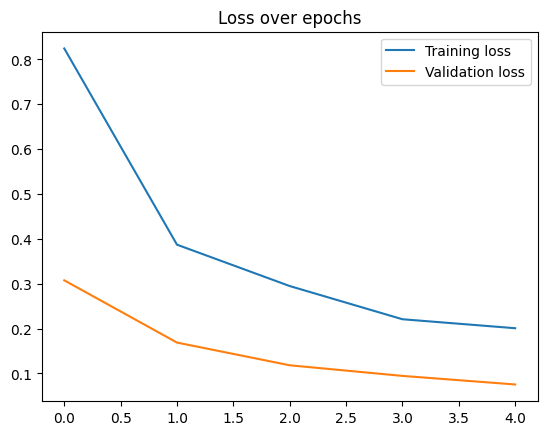

In [103]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# **Bonus:** Evaluating the Results



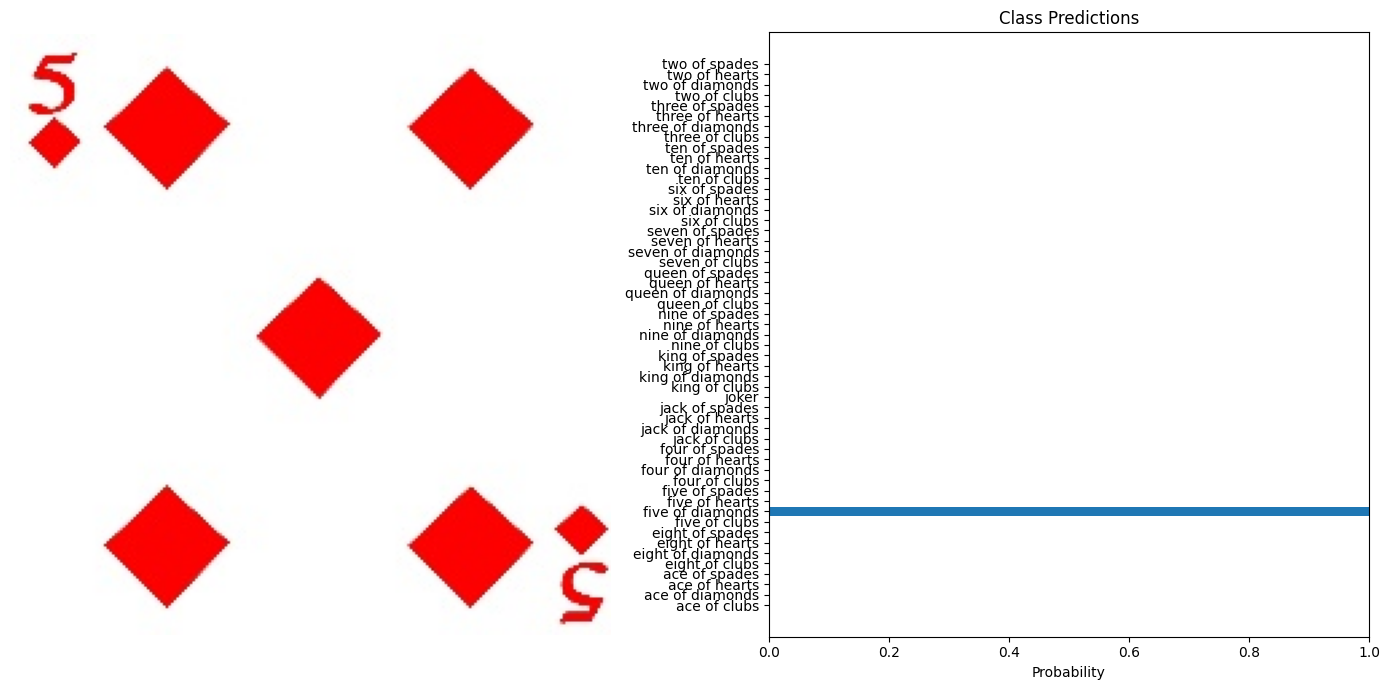

In [104]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

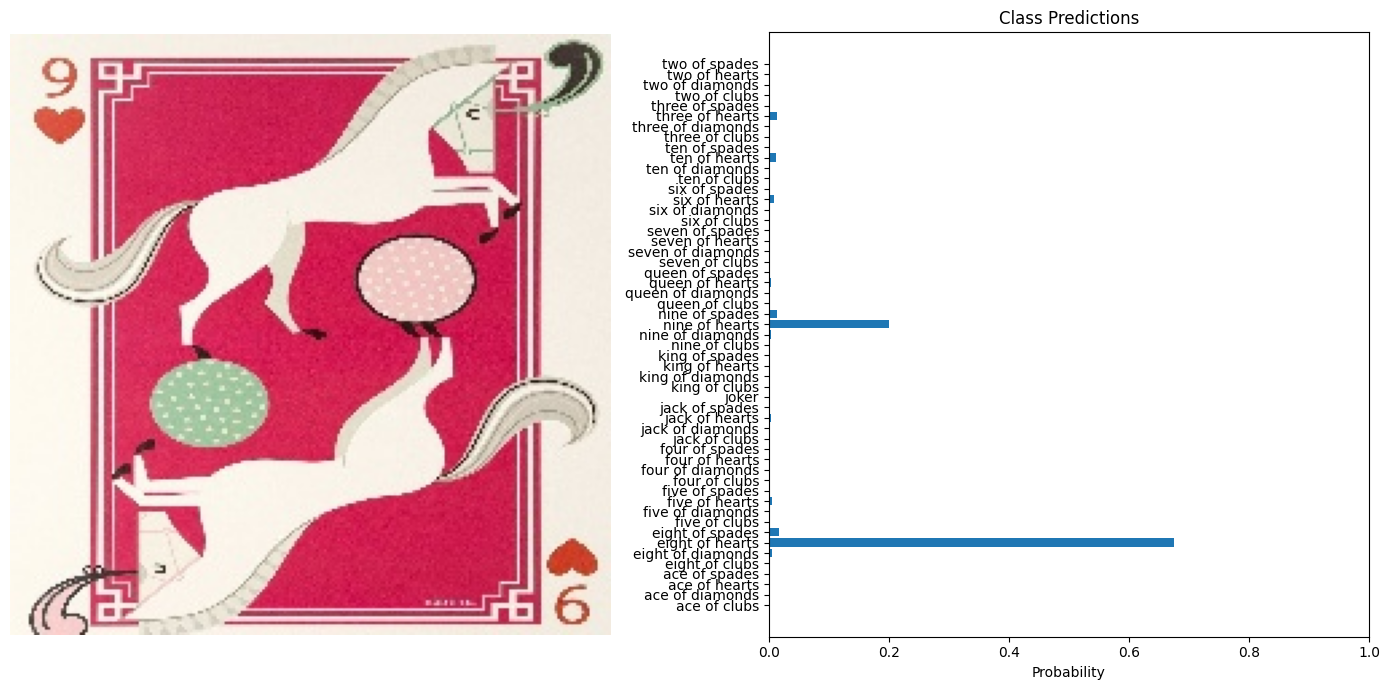

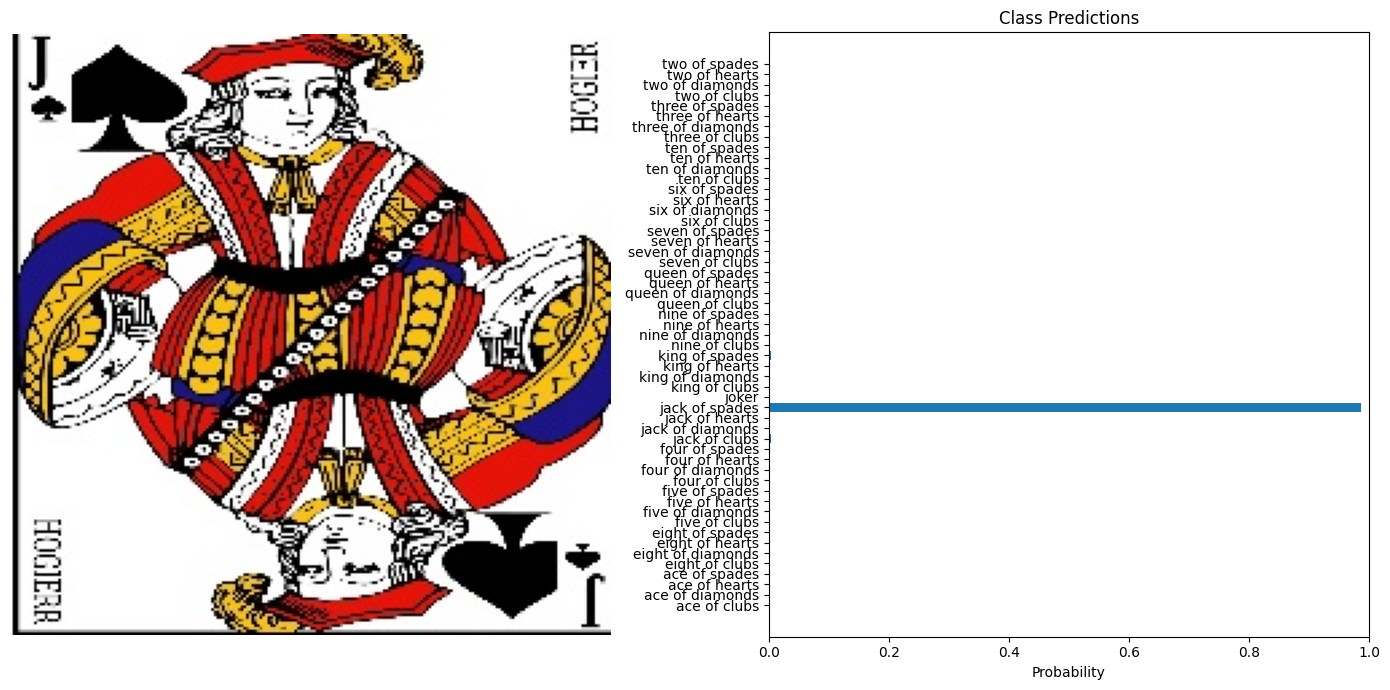

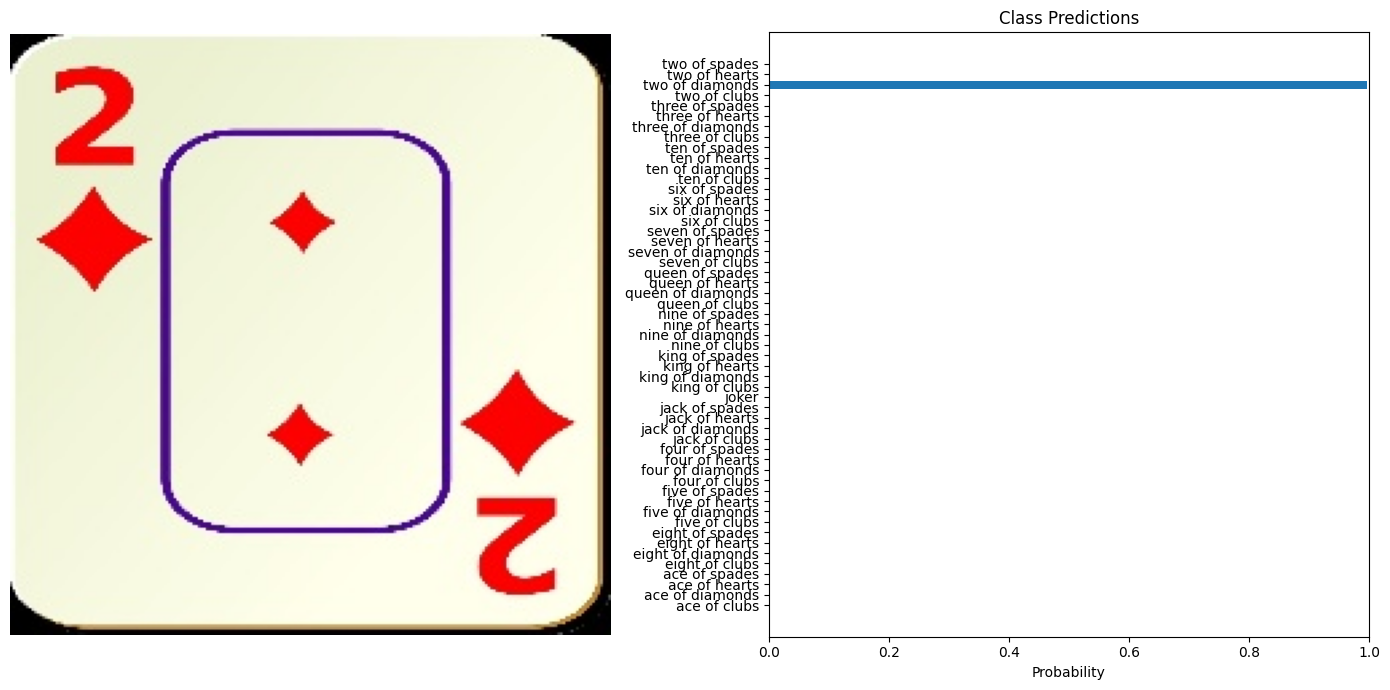

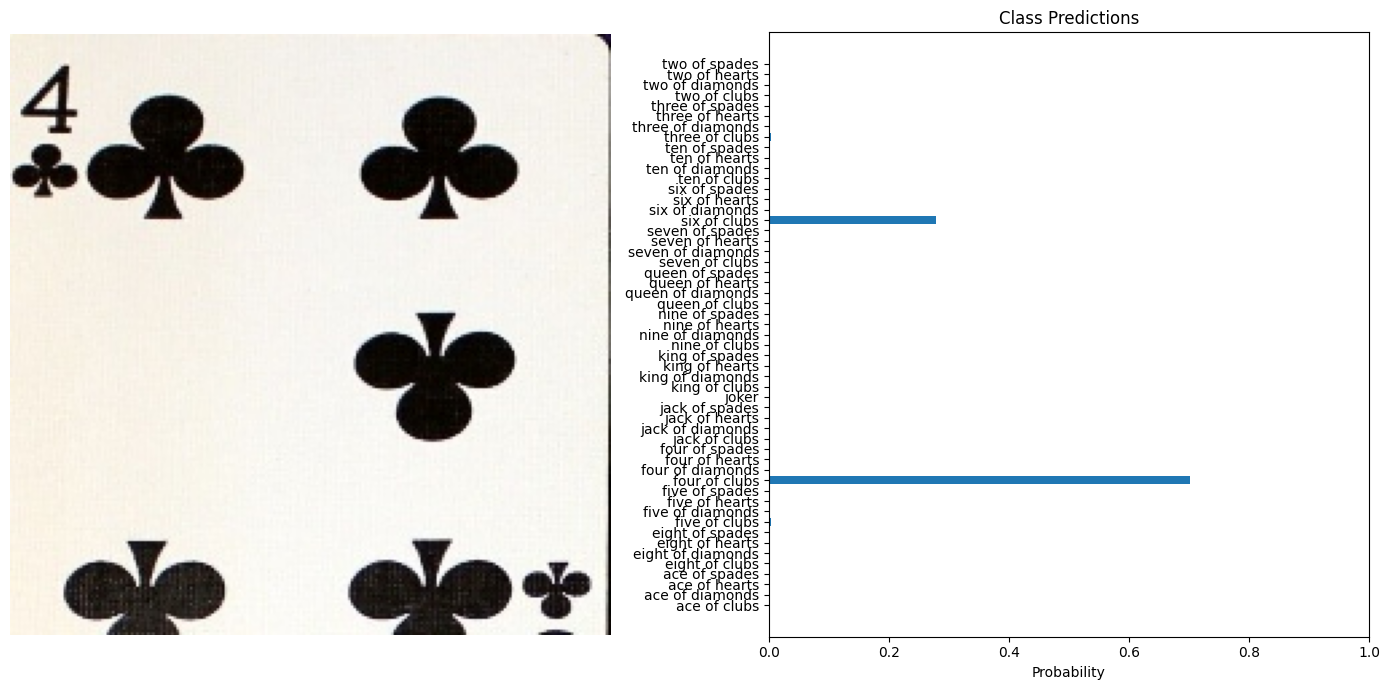

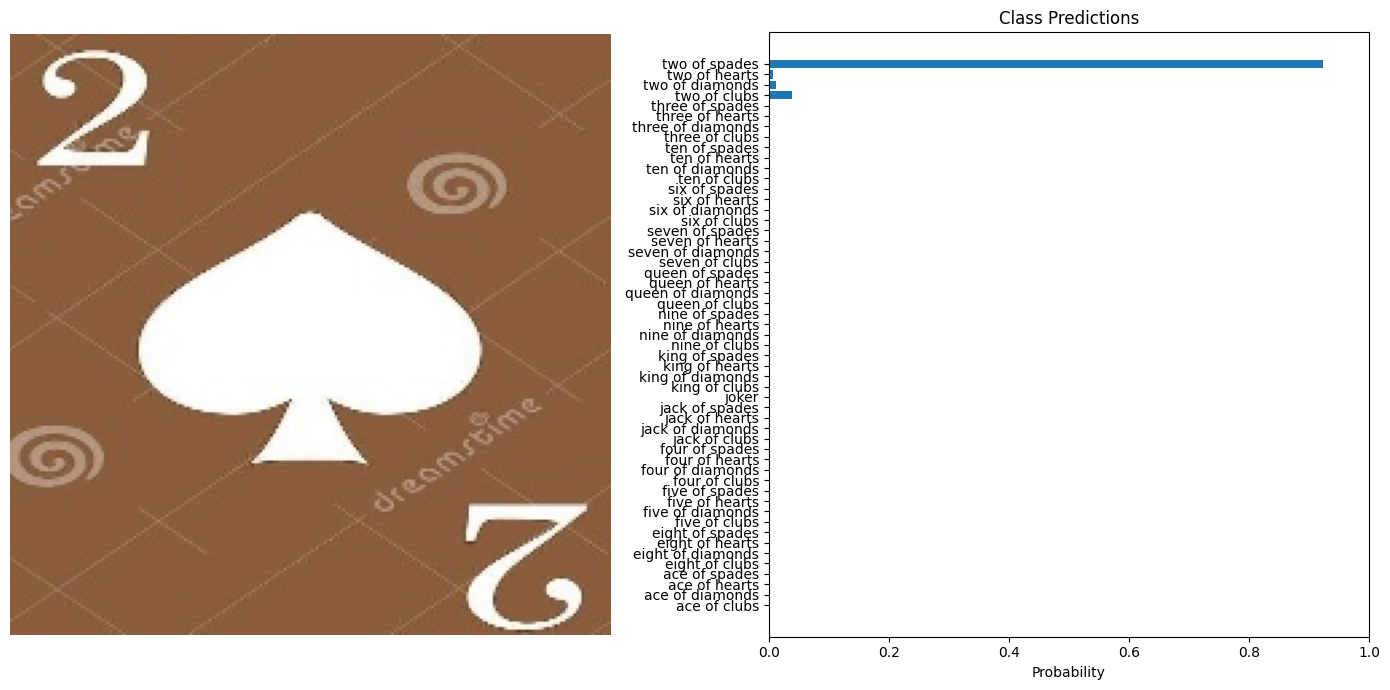

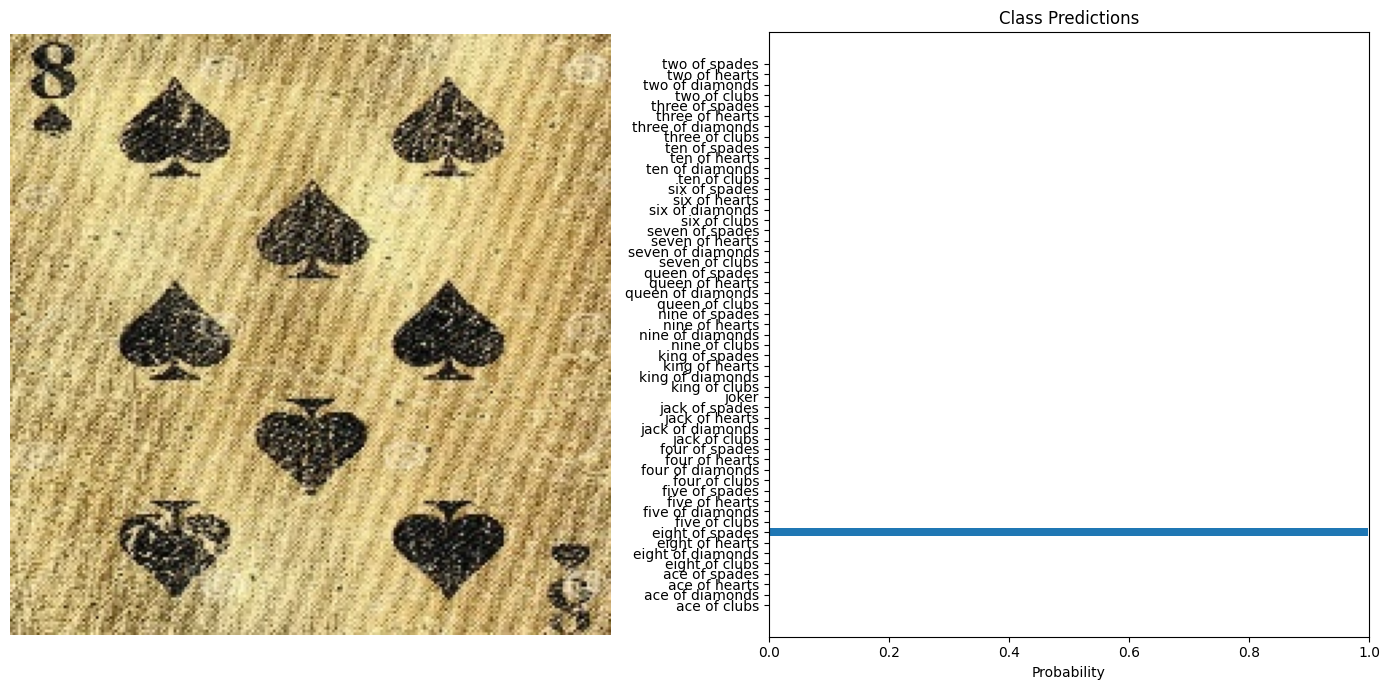

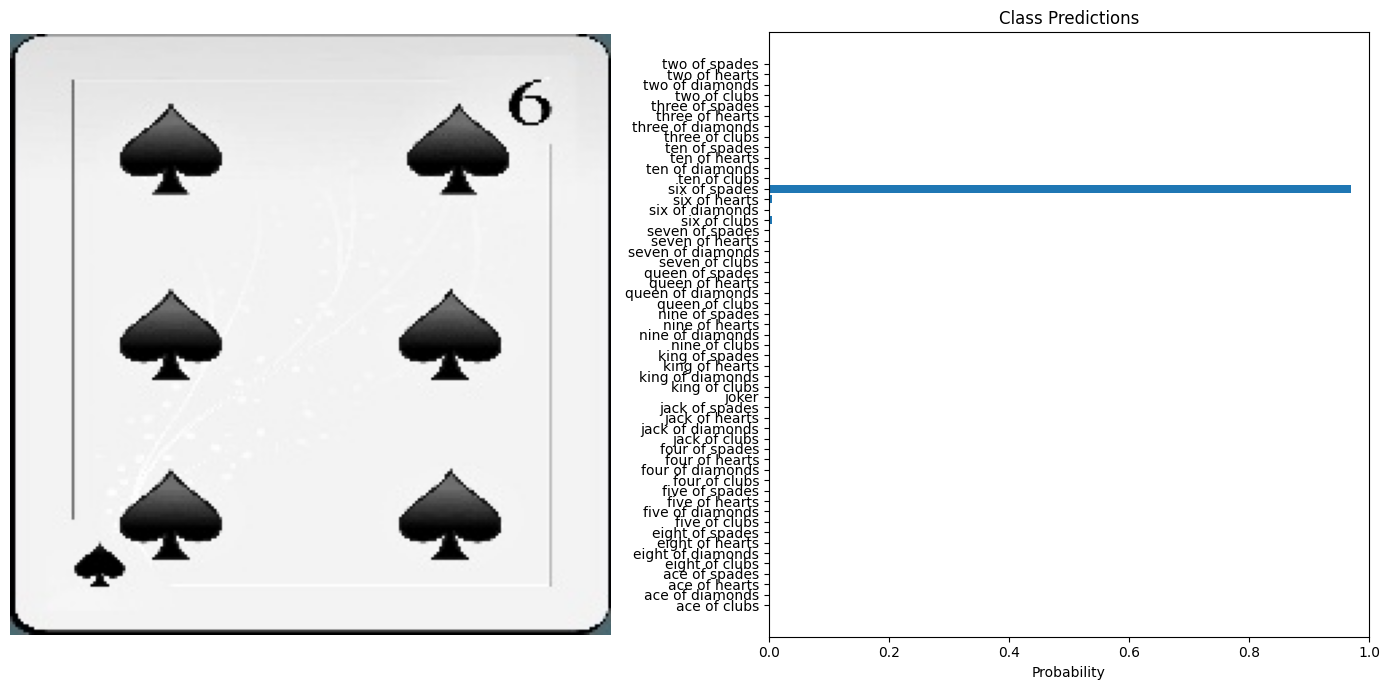

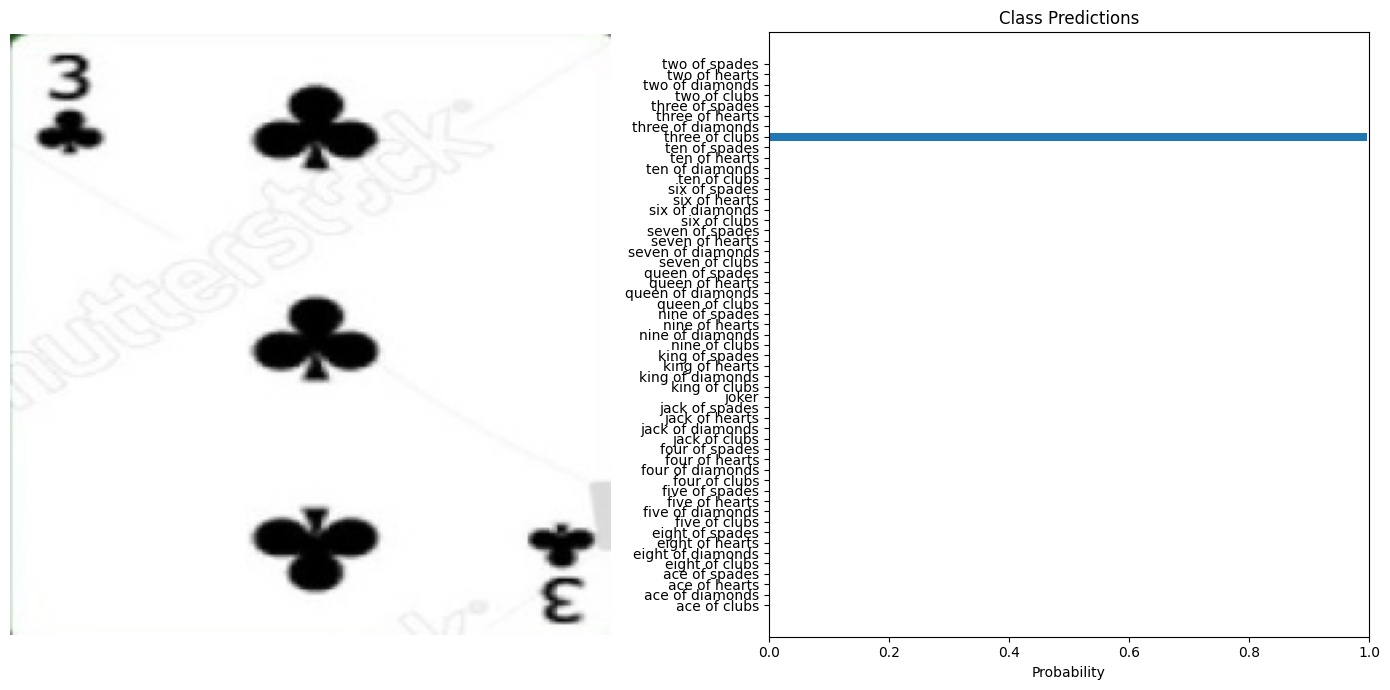

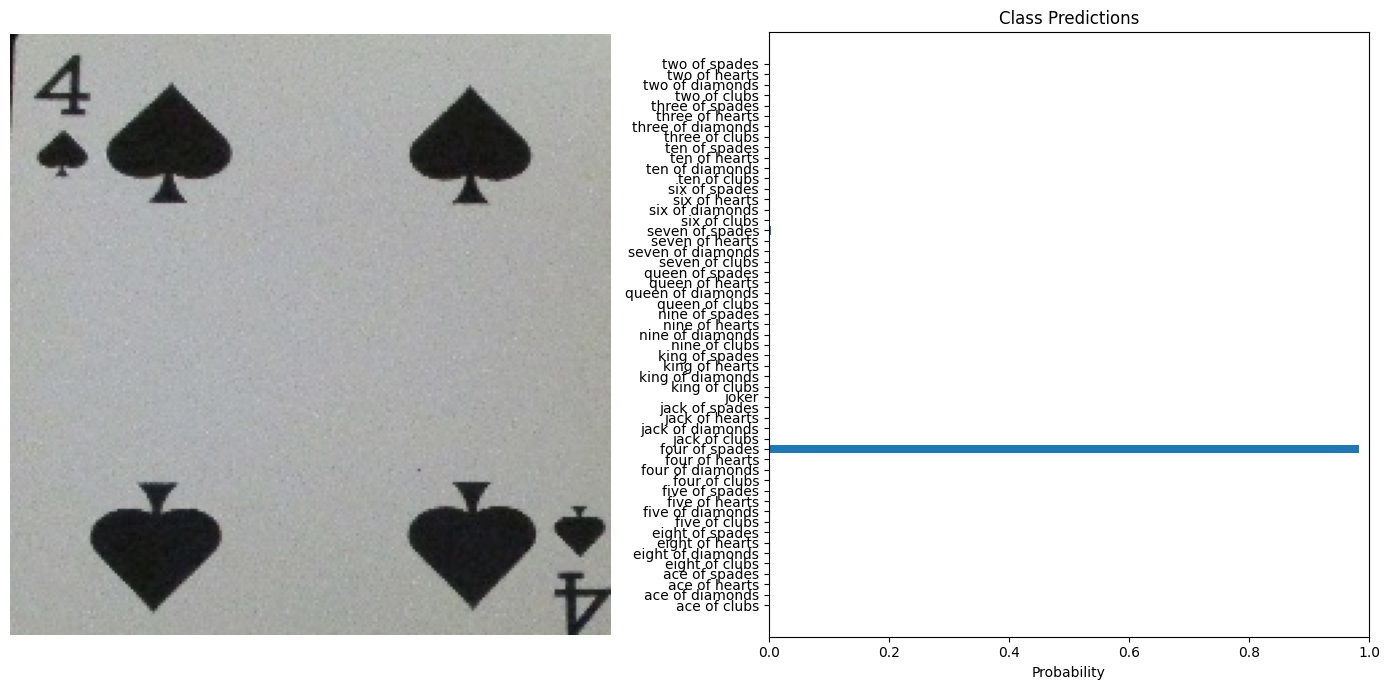

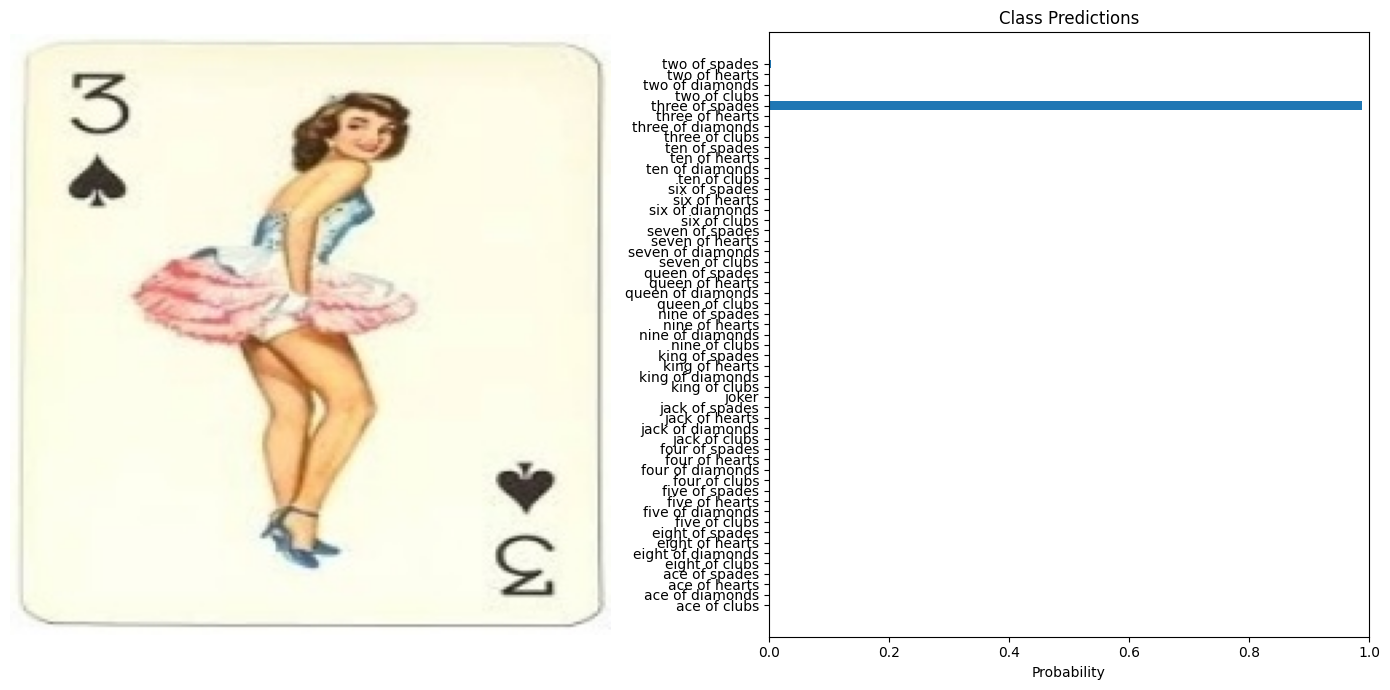

In [105]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

# Todo

- Calculate the accuracy of our model on the validation and test set.